# Catapult codesign

Model: `(13,21,2)` or `(13,21,20)`

## List trained models

In [1]:
!for f in `ls weights/weights_7pitches/*json`; do basename $f | grep -oP '(?<=best_model_dataset_2s_50x12P5x100_).*?(?=_architecture.json)'; done

timeslices20_bs1000_xysum
timeslices2_bs1000_xysum
timeslices2_bs5000_xysum


## Setup

Please follow [these instructions](https://github.com/GiuseppeDiGuglielmo/catapult_venvs) to setup an environment for Catapult AI NN (_hls4ml_).

You can either use the _hls4ml_ release with Catapult (2024.2_1) or point to a Siemens or official GitHub repository. [Here we provide some details.](https://github.com/GiuseppeDiGuglielmo/catapult_compare_releases)

In [2]:
# Path to the Catapult installation directory
!echo $MGC_HOME

/extras2/tools/Siemens/catapult/2024.2_2/Mgc_home


In [3]:
# Path to the hls4ml installation directory
# It can be point to either the Catapult installation directory or a copy of Siemens/Official GitHub repo 
!echo $PYTHONPATH

/extras2/tools/Siemens/catapult/2024.2_2/Mgc_home/shared/pkgs/ccs_hls4ml/hls4ml


## Import libraries

Disable some console warnings on the ASIC-group servers

In [4]:
import os

In [5]:
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [6]:
import hls4ml

import numpy as np
import math
import yaml
import json

from xysum_model import *


from matplotlib import colors

from loss import *
from qkeras import quantized_bits

import matplotlib.pyplot as plt

## Set parameters

In [7]:
# Choose model type
model_type = "xysum" 

# True = use all of the time slices, False = use a subset of the timeslices
timeslices_all_enable = False

#batch_size = 1000
batch_size = 5000

In [8]:
# See: https://docs.google.com/document/d/1ZoqVyJOOAXhzt2egMWh3OoNJ6lWq5lNR6sjcYON4Vlo/edit?tab=t.0#heading=h.k6tyal7z5t5l
dataset_name = "dataset_2s"
# 50x12.5x100 micron pixel sensor => 13x21 pixel sensor array
sensor_geometry_name = "50x12P5x100"
# Either 20 or 2 timeslices
timeslices_name = "timeslices20" if timeslices_all_enable else "timeslices2"
timeslices_range = -1 if timeslices_all_enable else [0, 19]
timeslices_val = 20 if timeslices_all_enable else 2
#
batch_size_name = f"bs{batch_size}"

In [9]:
# You can define a JSON configuration file locally
# {
#    "data_base_dir": "/data/dajiang/smartPixels",
#    "tfrecords_base_dir" : "/data/dajiang/smartPixels",
#    "model_base_dir": "/home/dajiang/smart-pixels-ml/weights"
# }
config_file_path = 'config.json'

# If the file does not exist, the notebook uses default values for those entries
data_base_dir = "/data/dajiang/smartPixels/dataset_2s"
tfrecords_base_dir = "/data/dajiang/smartPixels/tfrecords"
npy_base_dir = "/data/dajiang/smartPixels/npy"
model_base_dir = "/home/dajiang/smart-pixels-ml/weights"

if os.path.exists(config_file_path):
    with open(config_file_path, 'r') as file:
        data = json.load(file)
        data_base_dir = data.get('data_base_dir')
        tfrecords_base_dir = data.get('tfrecords_base_dir')
        npy_base_dir = data.get('npy_base_dir')
        model_base_dir = data.get('model_base_dir')
    print(f"Use config info from file: {data_base_dir}, {tfrecords_base_dir}, {npy_base_dir}, {model_base_dir}")
else:
    print(f"File does not exist. Use default config info: {data_base_dir}, {tfrecords_base_dir}, {npy_base_dir}, {model_base_dir}")

Use config info from file: /home/giuseppe/research/projects/smartpixels/data/dataset_2s, /home/giuseppe/research/projects/smartpixels/lindsey-smart-pixels-ml/tfrecords, /home/giuseppe/research/projects/smartpixels/lindsey-smart-pixels-ml/npy, /home/giuseppe/research/projects/smartpixels/lindsey-smart-pixels-ml/weights


In [10]:
#model_name = f"{dataset_name}_{sensor_geometry_name}_{timeslices_name}_{batch_size_name}" + ("_bnorm" if batch_norm_enabled else "")
model_name = f"{dataset_name}_{sensor_geometry_name}_{timeslices_name}_{batch_size_name}" + (("_" if model_type != "" else "") + model_type)

best_model_weights_hdf5 = f"{model_base_dir}/weights_7pitches/best_model_{model_name}_weights.hdf5"
best_model_architecture_json = f"{model_base_dir}/weights_7pitches/best_model_{model_name}_architecture.json"
best_model_hdf5 = f"{model_base_dir}/weights_7pitches/best_model_{model_name}.hdf5"

In [11]:
print(model_name)

dataset_2s_50x12P5x100_timeslices2_bs5000_xysum


## Load data

In [12]:
X = np.load(f'{npy_base_dir}/X_{timeslices_name}_val.npy')[:batch_size,]
y = np.load(f'{npy_base_dir}/y_{timeslices_name}_val.npy')[:batch_size,]

In [13]:
print(X.shape)
print(y.shape)

(5000, 13, 21, 2)
(5000, 4)


### Visualize data

Data visualization can also be moved to a different notebook, which may also already exists.

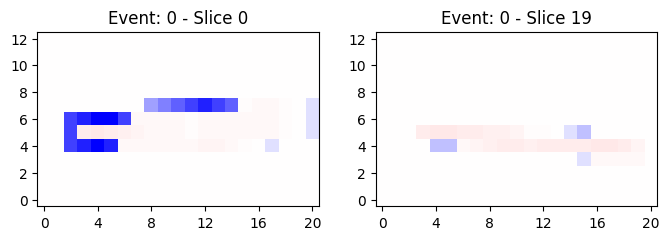

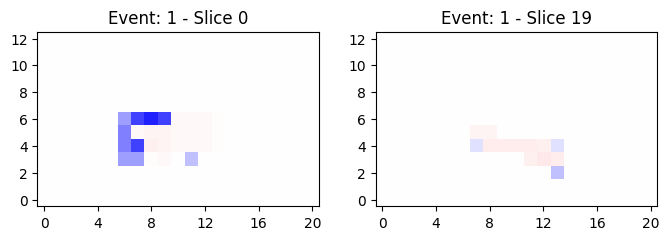

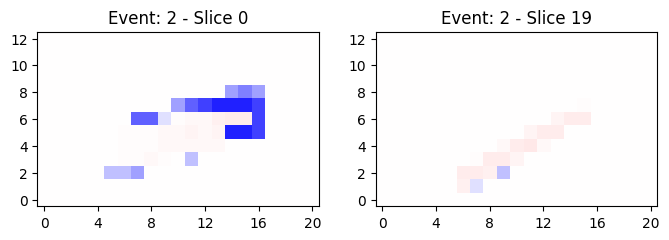

In [14]:
def plot_event(X, timeslices_range, index):
    if index < 0 or index >= X.shape[0]:
        print("Index out of range. Please provide a valid index.")
        return

    timeslices_range = np.arange(20) if timeslices_range == -1 else timeslices_range
    
    slices_num = X[index].shape[2]
    
    fig, axes = plt.subplots(1, slices_num, figsize=(slices_num*4, 16))

    divnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=8.5)

    imgs = []
    for i_slice in range(slices_num):
        img = axes[i_slice].imshow(X[index, :, :, i_slice], interpolation='nearest', origin='lower', cmap='bwr', norm=divnorm)
        axes[i_slice].set_title(f'Event: {index} - Slice {timeslices_range[i_slice]}')
        axes[i_slice].set_xticks(range(0, X.shape[2], max(1, X.shape[2] // 5)))
        axes[i_slice].set_yticks(range(0, X.shape[1], max(1, X.shape[1] // 5)))

    plt.show()

# Plot some images
for i in range(3):
    plot_event(X, timeslices_range, i)

In [15]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_event(X, timeslices_range, index):
    if index < 0 or index >= X.shape[0]:
        print("Index out of range. Please provide a valid index.")
        return

    timeslices_range = np.arange(20) if timeslices_range == -1 else timeslices_range
    
    slices_num = X[index].shape[2]
    fig, ax = plt.subplots(figsize=(8, 4))

    divnorm = colors.TwoSlopeNorm(vmin=-1., vcenter=0., vmax=8.5)
    img = ax.imshow(X[index, :, :, 0], interpolation='nearest', origin='lower', cmap='bwr', norm=divnorm)

    ax.set_title(f'Event: {index} - Slice 0')
    ax.set_xticks(range(0, X.shape[2], max(1, X.shape[2] // 5)))
    ax.set_yticks(range(0, X.shape[1], max(1, X.shape[1] // 5)))

    def update(frame):
        img.set_data(X[index, :, :, frame])
        ax.set_title(f'Event: {index} - Slice {timeslices_range[frame]}')
        return img, ax

    ani = FuncAnimation(fig, update, frames=slices_num, blit=False, interval=500)

    plt.close(fig)
    return ani

ani = animate_event(X, timeslices_range, 2)
#ani.save("animation.mp4", fps=2)
#ani.save(f"{dataset_name}_{sensor_geometry_name}_{timeslices_name}_{batch_size_name}_animation.gif", writer='imagemagick')

HTML(ani.to_jshtml())

### Quantize data

<b style="background-color: yellow; color: red">ATTENTION: Input quantization is disabled. The _hls4ml_ implementation uses the default value: <i style="font-family: Courier;">fixed<16,6></i></b>

## QKeras model

### Load QKeras model

In [16]:
# Load the whole model from HDF5 file
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {"custom_loss": custom_loss}
_add_supported_quantized_objects(co)
model = load_model(best_model_hdf5, custom_objects=co)
model.summary(line_length=120, show_trainable=True)

Model: "smrtpxl_regression"
___________________________________________________________________________________________________________________________________
 Layer (type)                       Output Shape                        Param #     Connected to                        Trainable  
 input_pxls (InputLayer)            [(None, 13, 21, 2)]                 0           []                                  Y          
                                                                                                                                   
 avg_pooling_2d_proj_x (AveragePoo  (None, 13, 1, 2)                    0           ['input_pxls[0][0]']                Y          
 ling2D)                                                                                                                           
                                                                                                                                   
 avg_pooling_2d_proj_y (AveragePoo  (None, 1, 21

In [17]:
# TODO: This gives an error:
# ValueError: Layer count mismatch when loading weights from file. Model expected 5 layers, found 9 saved layers.
#
# # Load model weights from HDF5 file, while recreate architecture from scripts
# model = CreateModel((13,21,2), n_filters=5, pool_size=3)
# model.load_weights(best_model_weights_hdf5)
# model.summary(line_length=200)

### Slice QKeras model

<b style="background-color: yellow; color: red">ATTENTION: You can select a subset of layers of the model (slice) to debug the HLS implementation.</b>

In [18]:
#sliced_model_enable = False
sliced_model_enable = False
slice_from_layer_num = 6
slice_to_layer_num = 6
slice_away_last_activation = True

In [19]:
# for l in model.layers:
#     print(l, l.input)
#     print(l, l.output)

In [20]:
if sliced_model_enable:
    print("Layer count: {}/{}".format(slice_to_layer_num, len(model.layers)-1))
    assert(slice_to_layer_num < len(model.layers))
    model_head = Model(inputs=model.input,
                  outputs=model.layers[slice_to_layer_num-1].output)

    model_head.summary(line_length=120, show_trainable=True)

    from tensorflow.keras.utils import plot_model
    plot_model(model_head, to_file=f"{model_name}_model_head.png", show_shapes=True, show_layer_names=True)


if sliced_model_enable:

    assert slice_from_layer_num < len(model.layers), f"slice_from_layer_num ({slice_from_layer_num}) exceeds layer count ({len(model.layers)})"
    assert slice_to_layer_num < len(model.layers), f"slice_to_layer_num ({slice_to_layer_num}) exceeds layer count ({len(model.layers)})"
    assert slice_from_layer_num <= slice_to_layer_num, "slice_from_layer_num must be less than or equal to slice_to_layer_num"

    print("Layer count: {}/{}".format(slice_to_layer_num, len(model.layers) - 1))

    # Create new input tensor based on the shape of the selected layer
    input_shape = model.layers[slice_from_layer_num].input_shape[1:]
    new_input = tf.keras.layers.Input(shape=input_shape)

    # Connect the new input to the desired layers
    x = model.layers[slice_from_layer_num](new_input)
    for i in range(slice_from_layer_num + 1, slice_to_layer_num + 1):
        x = model.layers[i](x)

    # Create a new sliced model
    model = Model(inputs=new_input, outputs=x)
    model.summary(line_length=120, show_trainable=True)

    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file=f"{model_name}_model.png", show_shapes=True, show_layer_names=True)

### Run QKeras model

In [21]:
print(f'Input batch: {X.shape[0]}')
print(f'Input shape: {X.shape}')

Input batch: 5000
Input shape: (5000, 13, 21, 2)


#### Prediction

In [22]:
if sliced_model_enable:
    y_head_qkeras = model_head.predict(np.ascontiguousarray(X))
    y_qkeras = model.predict(y_head_qkeras)
else:
    y_qkeras = model.predict(np.ascontiguousarray(X))
print(f'QKeras output batch: {y_qkeras.shape[0]}')
print(f'QKeras output shape: {y_qkeras.shape}')

157/157 [==============================] - 1s 2ms/step
QKeras output batch: 5000
QKeras output shape: (5000, 14)


#### Profiling

In [23]:
trace_qkeras = hls4ml.model.profiling.get_ymodel_keras(model, X)
#print(trace_qkeras['q_separable_conv2d'].shape)

157/157 [==============================] - 0s 1ms/step
Done taking outputs for Keras model.


In [24]:
for key in trace_qkeras.keys():
    print(f'QKeras layer trace shape: {key} {trace_qkeras[key].shape}')

QKeras layer trace shape: avg_pooling_2d_proj_x (5000, 13, 1, 2)
QKeras layer trace shape: avg_pooling_2d_proj_y (5000, 1, 21, 2)
QKeras layer trace shape: reshape_proj_x (5000, 13, 2)
QKeras layer trace shape: reshape_proj_y (5000, 21, 2)
QKeras layer trace shape: conv1d_proj_x (5000, 11, 5)
QKeras layer trace shape: conv1d_proj_y (5000, 19, 5)
QKeras layer trace shape: concatenate (5000, 30, 5)
QKeras layer trace shape: activation_tanh_1 (5000, 30, 5)
QKeras layer trace shape: flatten (5000, 150)
QKeras layer trace shape: dense_1 (5000, 16)
QKeras layer trace shape: activation_tanh_2 (5000, 16)
QKeras layer trace shape: dense_2 (5000, 16)
QKeras layer trace shape: activation_tanh_3 (5000, 16)
QKeras layer trace shape: dense_3 (5000, 14)


#### Save .dat files

In [25]:
# Save input features and model predictions just the top 20
np.savetxt(f"{model_name}_tb_input_features.dat", X.reshape(batch_size, -1), fmt="%f")
np.savetxt(f"{model_name}_tb_output_predictions.dat", y_qkeras.reshape(batch_size, -1), fmt="%f")
#np.savetxt("y_test_labels.dat", y_test, fmt="%d")

In [26]:
!wc -l *tb_input_features.dat
!wc -l *tb_output_predictions.dat

    1000 dataset_2s_50x12P5x100_timeslices20_bs1000_xysum_tb_input_features.dat
    1000 dataset_2s_50x12P5x100_timeslices2_bs1000_xysum_tb_input_features.dat
    5000 dataset_2s_50x12P5x100_timeslices2_bs5000_xysum_tb_input_features.dat
    7000 total
  1000 dataset_2s_50x12P5x100_timeslices20_bs1000_xysum_tb_output_predictions.dat
  1000 dataset_2s_50x12P5x100_timeslices2_bs1000_xysum_tb_output_predictions.dat
  5000 dataset_2s_50x12P5x100_timeslices2_bs5000_xysum_tb_output_predictions.dat
  7000 total


## hls4ml model

### Configure hls4ml model

In [27]:
project_name = "SmtPxl"

strategy = "Latency"
#strategy = "Resource"

#io_type = "io_stream"
io_type = "io_parallel"

build_bup = False
#build_bup = True

#programmable_weights = False
programmable_weights = True

hls4ml_output_dir = f"{project_name}_{io_type}_{strategy}{'_bup' if build_bup else ''}{'_pw' if programmable_weights else ''}{f'_slice{slice_from_layer_num}to{slice_to_layer_num}' if sliced_model_enable else ''}_hls4ml_prj"

print(hls4ml_output_dir)

#asiclibs = "saed32rvt_tt0p78v125c_beh"
asiclibs = "tcbn28hpcplusbwp30p140ssg0p81v125c_ccs_dc"
asiclibspath ='/home/giuseppe/research/projects/smartpixels/tsmc28nm_lib'

SmtPxl_io_parallel_Latency_pw_hls4ml_prj


In [28]:
!rm -rf $hls4ml_output_dir*

In [29]:
config_hls4ml = hls4ml.utils.config.create_config(
    backend = "Catapult",
    project_name = project_name,
    output_dir = hls4ml_output_dir,
    tech = "asic",
    asiclibs= asiclibs,
    asiclibspath = asiclibspath,
    asicfifo = "hls4ml_lib.mgc_pipe_mem",
    clock_period = 25,
    io_type = io_type,
    csim = False, SCVerify = False, Synth = False, BuildBUP = build_bup
)
#print(config_hls4ml)
#print(json.dumps(config_hls4ml, indent=4))

In [30]:
config_hls4ml["HLSConfig"] = hls4ml.utils.config_from_keras_model(
    model,
    granularity="name",
    default_precision="ac_fixed<16,6,true>",
    default_reuse_factor=1
)

config_hls4ml["HLSConfig"]["Model"]["Strategy"] = strategy

if programmable_weights:
    # All the weights are exposed through BRAMs
    config_hls4ml["HLSConfig"]["Model"]["BramFactor"] = 0

#config_hls4ml["HLSConfig"]['LayerName']['q_separable_conv2d']['ReuseFactor'] = 10
    
#print(config_hls4ml)
print(json.dumps(config_hls4ml, indent=4))

Interpreting Model
Topology:
Layer name: input_pxls, layer type: InputLayer, input shapes: [[None, 13, 21, 2]], output shape: [None, 13, 21, 2]
Layer name: avg_pooling_2d_proj_x, layer type: AveragePooling2D, input shapes: [[None, 13, 21, 2]], output shape: [None, 13, 1, 2]
Layer name: avg_pooling_2d_proj_y, layer type: AveragePooling2D, input shapes: [[None, 13, 21, 2]], output shape: [None, 1, 21, 2]
Layer name: reshape_proj_x, layer type: Reshape, input shapes: [[None, 13, 1, 2]], output shape: [None, 13, 2]
Layer name: reshape_proj_y, layer type: Reshape, input shapes: [[None, 1, 21, 2]], output shape: [None, 21, 2]
Layer name: conv1d_proj_x, layer type: QConv1D, input shapes: [[None, 13, 2]], output shape: [None, 11, 5]
Layer name: conv1d_proj_y, layer type: QConv1D, input shapes: [[None, 21, 2]], output shape: [None, 19, 5]
Layer name: concatenate, layer type: Concatenate, input shapes: [[None, 11, 5], [None, 19, 5]], output shape: [None, 30, 5]
Layer name: activation_tanh_1, lay

/home/giuseppe/ccs_venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


<b style="background-color: yellow; color: red">ATTENTION: The model precision can be fine tuned here.</b>

In [31]:
# NOTE: fine tune average-pooling-2d
# TODO: Can this be fixed directly in the average-pooling-2d implementation?
if not sliced_model_enable:
    config_hls4ml["HLSConfig"]['LayerName']['input_pxls']['Precision']['result'] = 'fixed<4,1>'
    config_hls4ml["HLSConfig"]['LayerName']['avg_pooling_2d_proj_x']['Precision']['result'] = 'fixed<11,1>'
    config_hls4ml["HLSConfig"]['LayerName']['avg_pooling_2d_proj_y']['Precision']['result'] = 'fixed<11,1>'
    config_hls4ml["HLSConfig"]['LayerName']['dense_3']['Precision']['result'] = 'fixed<8,2>'
    config_hls4ml["HLSConfig"]['LayerName']['dense_3_linear']['Precision']['result'] = 'fixed<8,2>'

In [32]:
if sliced_model_enable:
    model.save_weights(f"{model_name}_debug.hdf5")
    model_json = model.to_json()
    with open(f"{model_name}_debug.json", "w") as json_file:
        json_file.write(model_json)

In [33]:
# Point to the model definition, weights/biase values and C++ testbench data files
config_hls4ml["KerasH5"] = best_model_weights_hdf5 if not sliced_model_enable else f"{model_name}_debug.hdf5"
config_hls4ml["KerasJson"] = best_model_architecture_json if not sliced_model_enable else f"{model_name}_debug.json"
config_hls4ml["InputData"] = f"{model_name}_tb_input_features.dat"
config_hls4ml["OutputPredictions"] = f"{model_name}_tb_output_predictions.dat"
#print(config_hls4ml)
#print(json.dumps(config_hls4ml, indent=4))

In [34]:
# TODO: is this necessary?
with open(f"{model_name}_myproject_config.yml", "w") as yaml_file:
    yaml.dump(config_hls4ml, yaml_file, explicit_start=False, default_flow_style=False)

In [35]:
# Enable tracing for all of the layers
for layer in config_hls4ml["HLSConfig"]["LayerName"].keys():
    print("Enable tracing for layer:", layer)
    config_hls4ml["HLSConfig"]["LayerName"][layer]["Trace"] = True

Enable tracing for layer: input_pxls
Enable tracing for layer: avg_pooling_2d_proj_x
Enable tracing for layer: avg_pooling_2d_proj_y
Enable tracing for layer: reshape_proj_x
Enable tracing for layer: reshape_proj_y
Enable tracing for layer: conv1d_proj_x
Enable tracing for layer: conv1d_proj_x_linear
Enable tracing for layer: conv1d_proj_y
Enable tracing for layer: conv1d_proj_y_linear
Enable tracing for layer: concatenate
Enable tracing for layer: activation_tanh_1
Enable tracing for layer: flatten
Enable tracing for layer: dense_1
Enable tracing for layer: dense_1_linear
Enable tracing for layer: activation_tanh_2
Enable tracing for layer: dense_2
Enable tracing for layer: dense_2_linear
Enable tracing for layer: activation_tanh_3
Enable tracing for layer: dense_3
Enable tracing for layer: dense_3_linear


In [36]:
# Convert QKeras model to Catapult HLS C++
hls_model_hls4ml = hls4ml.converters.keras_to_hls(config_hls4ml)

Interpreting Model
Topology:
Layer name: input_pxls, layer type: InputLayer, input shapes: [[None, 13, 21, 2]], output shape: [None, 13, 21, 2]
Layer name: avg_pooling_2d_proj_x, layer type: AveragePooling2D, input shapes: [[None, 13, 21, 2]], output shape: [None, 13, 1, 2]
Layer name: avg_pooling_2d_proj_y, layer type: AveragePooling2D, input shapes: [[None, 13, 21, 2]], output shape: [None, 1, 21, 2]
Layer name: reshape_proj_x, layer type: Reshape, input shapes: [[None, 13, 1, 2]], output shape: [None, 13, 2]
Layer name: reshape_proj_y, layer type: Reshape, input shapes: [[None, 1, 21, 2]], output shape: [None, 21, 2]
Layer name: conv1d_proj_x, layer type: QConv1D, input shapes: [[None, 13, 2]], output shape: [None, 11, 5]
Layer name: conv1d_proj_y, layer type: QConv1D, input shapes: [[None, 21, 2]], output shape: [None, 19, 5]
Layer name: concatenate, layer type: Concatenate, input shapes: [[None, 11, 5], [None, 19, 5]], output shape: [None, 30, 5]
Layer name: activation_tanh_1, lay

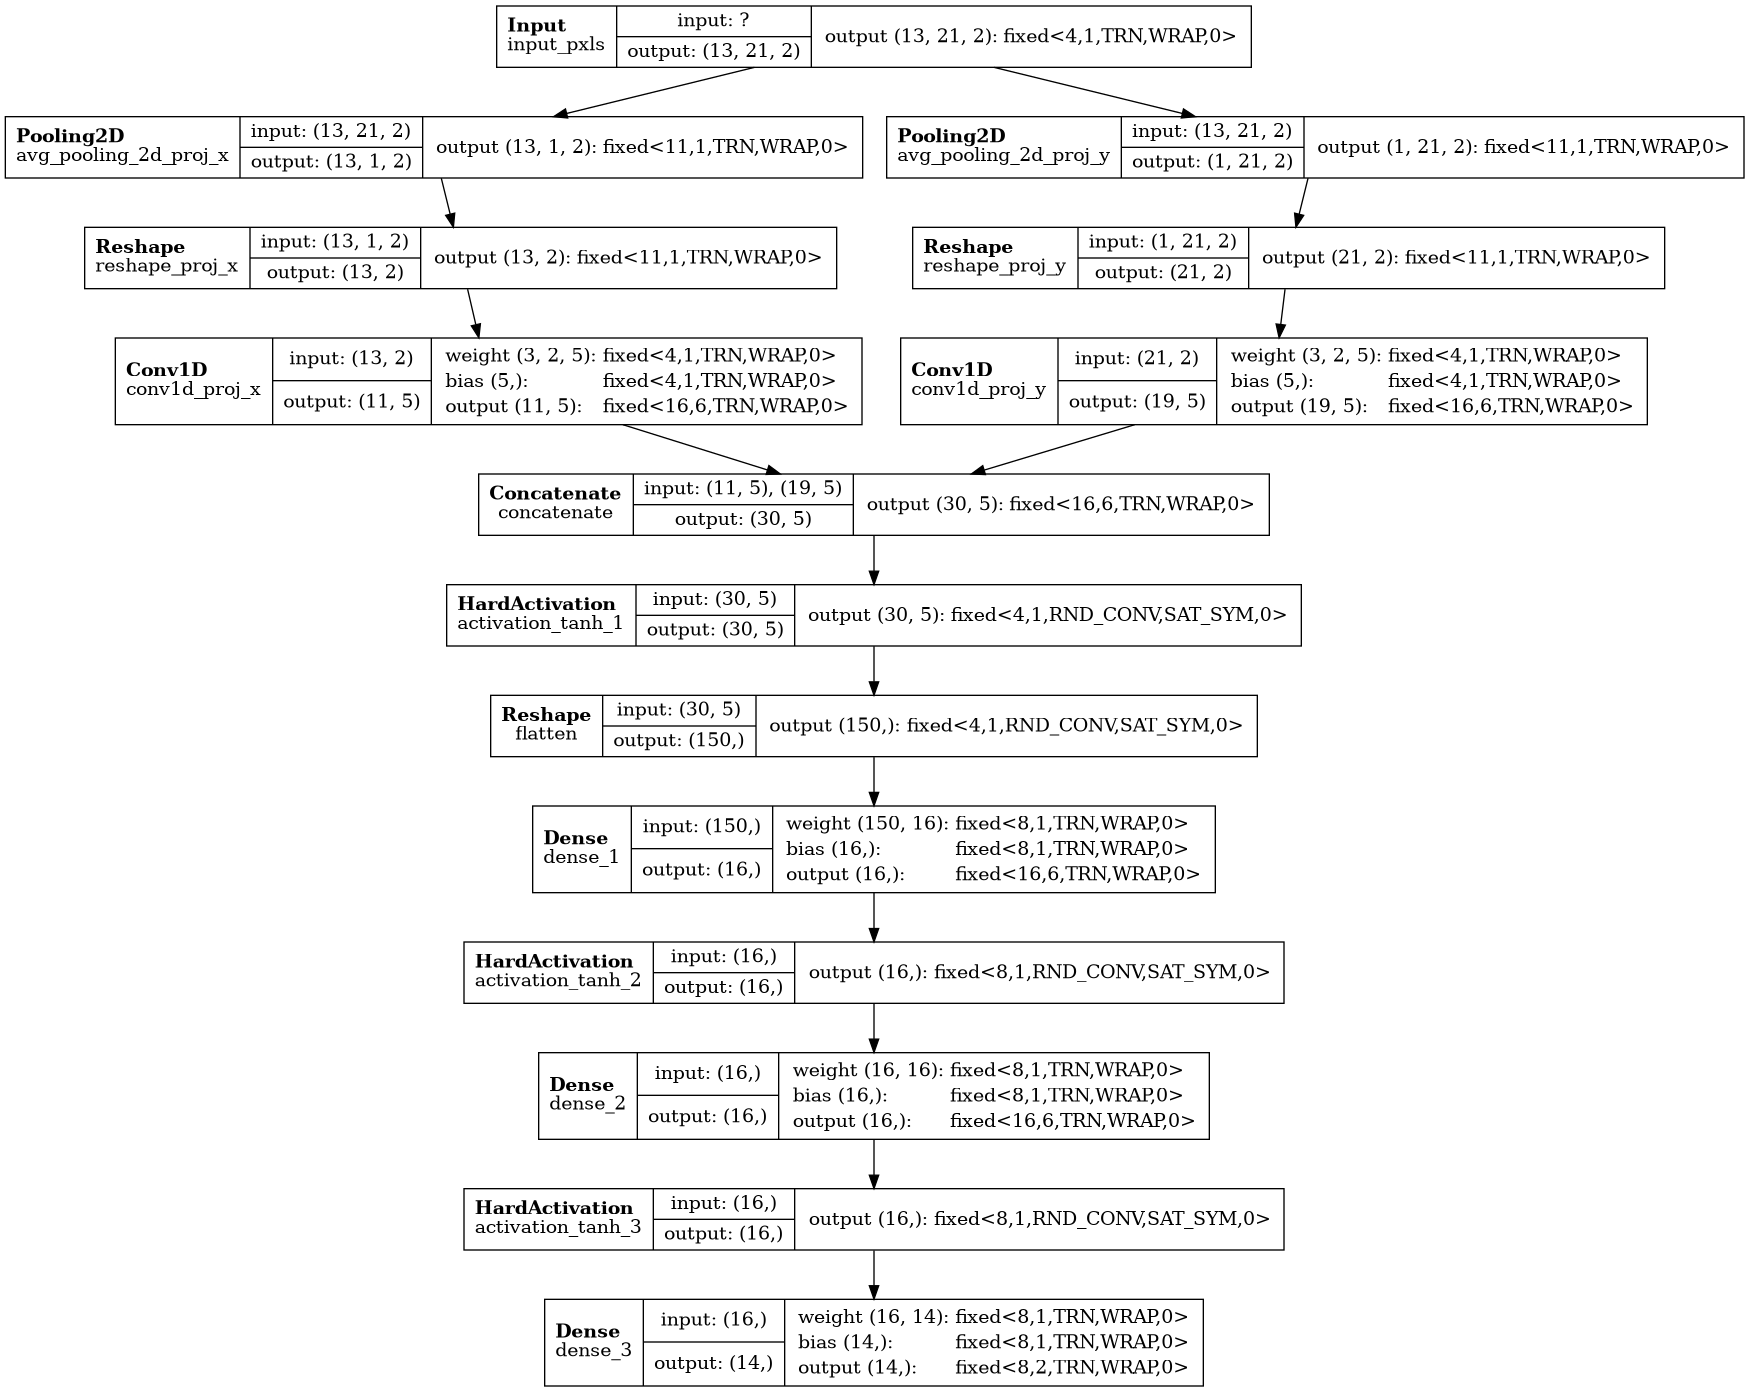

In [37]:
hls4ml.utils.plot_model(hls_model_hls4ml, show_shapes=True, show_precision=True, to_file=f"{model_name}_qkeras.png")
hls4ml.utils.plot_model(hls_model_hls4ml, show_shapes=True, show_precision=True, to_file=None)

In [38]:
# Writing HLS project
hls_model_hls4ml.compile()

Writing HLS project
... skipping copy of NNET headers from /extras2/tools/Siemens/catapult/2024.2_2/Mgc_home/shared/include/nnet_utils/
... skipping copy of ac_types headers - assumed to located in Catapult install tree
... skipping copy of ac_math headers - assumed to located in Catapult install tree
... skipping copy of ac_simutils headers - assumed to located in Catapult install tree
Done


### Run hls4ml model

#### Prediction

In [39]:
y_hls4ml = hls_model_hls4ml.predict(np.ascontiguousarray(X))

In [40]:
print(f'hls4ml output batch: {y_hls4ml.shape[0]}')
print(f'hls4ml output shape: {y_hls4ml.shape}')

hls4ml output batch: 5000
hls4ml output shape: (5000, 14)


#### Profiling

In [41]:
# Run tracing on the test set for the hls4ml model (fixed-point precision) 
pred_hls4ml, trace_hls4ml = hls_model_hls4ml.trace(X)

Recompiling SmtPxl with tracing
Writing HLS project
... skipping copy of NNET headers from /extras2/tools/Siemens/catapult/2024.2_2/Mgc_home/shared/include/nnet_utils/
... skipping copy of ac_types headers - assumed to located in Catapult install tree
... skipping copy of ac_math headers - assumed to located in Catapult install tree
... skipping copy of ac_simutils headers - assumed to located in Catapult install tree
Done


In [42]:
print(f'hls4ml output shape: {pred_hls4ml.shape}')
# print(f"hls4ml trace  shape: {trace_hls4ml['q_separable_conv2d_pointwise'].shape}")

hls4ml output shape: (5000, 14)


In [43]:
# import numpy as np
# import pandas as pd

# X_df = pd.DataFrame(X.reshape(batch_size, -1))
# y_qkeras_df = pd.DataFrame(y_qkeras.reshape(batch_size, -1))
# y_hls4ml_df = pd.DataFrame(pred_hls4ml)

# # Save as CSV
# X_df.to_csv('X_data.csv', index=False, header=False)
# y_qkeras_df.to_csv('y_qkeras_data.csv', index=False, header=False)
# y_hls4ml_df.to_csv('y_hls4ml_data.csv', index=False, header=False)


# np.savetxt(f"{model_name}_tb_input_features.dat", X.reshape(batch_size, -1), fmt="%f")
# np.savetxt(f"{model_name}_tb_output_predictions.dat", y_qkeras.reshape(batch_size, -1), fmt="%f")

## Compare QKeras and hls4ml

#### Trace visual inspection

In [44]:
# Print the traces on console
N_ELEMENTS = 8

# Backup print options
bkp_threshold = np.get_printoptions()["threshold"]
bkp_linewidth = np.get_printoptions()["linewidth"]

# Set print options
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# print(trace_hls4ml.keys())
# print(trace_qkeras.keys())
for key in trace_hls4ml.keys():
    print("-------")
    print('QKeras: ', key.replace("_pointwise", ""), trace_qkeras[key].flatten().shape)
    print('hls4ml: ', key.replace("_pointwise", ""), trace_hls4ml[key].flatten().shape)
    print("[keras] ", key.replace("_pointwise", ""), trace_qkeras[key].flatten()[:N_ELEMENTS])
    print("[hls4ml]", key.replace("_pointwise", ""), trace_hls4ml[key].flatten()[:N_ELEMENTS])
    
# Restore print options
np.set_printoptions(threshold=bkp_threshold, linewidth=bkp_linewidth)

-------
QKeras:  avg_pooling_2d_proj_x (130000,)
hls4ml:  avg_pooling_2d_proj_x (130000,)
[keras]  avg_pooling_2d_proj_x [0.         0.         0.         0.         0.         0.         0.         0.04166667]
[hls4ml] avg_pooling_2d_proj_x [0.         0.         0.         0.         0.         0.         0.         0.04101562]
-------
QKeras:  avg_pooling_2d_proj_y (210000,)
hls4ml:  avg_pooling_2d_proj_y (210000,)
[keras]  avg_pooling_2d_proj_y [ 0.          0.          0.          0.         -0.17307693  0.         -0.08653846  0.04807692]
[hls4ml] avg_pooling_2d_proj_y [ 0.          0.          0.          0.         -0.17382812  0.         -0.08691406  0.04785156]
-------
QKeras:  conv1d_proj_x (275000,)
hls4ml:  conv1d_proj_x (275000,)
[keras]  conv1d_proj_x [ 0.          0.125       0.          0.125       0.         -0.03645834  0.16145834  0.03645834]
[hls4ml] conv1d_proj_x [ 0.          0.125       0.          0.125       0.         -0.03613281  0.16015625  0.03515625]
----

#### MSE per layer

In [45]:
def mse(actual, predicted):
    return ((actual - predicted) ** 2).mean()

# print(trace_hls4ml.keys())
# print(trace_hls4ml['q_separable_conv2d_pointwise'].shape)
# print(trace_qkeras['q_separable_conv2d'].shape)
 
for key in trace_hls4ml.keys():
    if key == "q_separable_conv2d_depthwise":
        continue
    print("-------")
    #print(trace_hls4ml[key].flatten().shape)
    #print(trace_qkeras[key.replace("_pointwise", "")].flatten().shape)
    print("MSE {} {}".format(
        key.replace("_pointwise", ""),
        mse(
            trace_hls4ml[key].flatten(), 
            trace_qkeras[key.replace("_pointwise", "")].flatten())))

-------
MSE avg_pooling_2d_proj_x 1.0328091804012729e-07
-------
MSE avg_pooling_2d_proj_y 1.421659163725053e-07
-------
MSE conv1d_proj_x 6.796076945647656e-07
-------
MSE conv1d_proj_y 1.7938789369509323e-06
-------
MSE concatenate 1.3853120890416903e-06
-------
MSE activation_tanh_1 0.00011229166557313874
-------
MSE dense_1 0.0012775479117408395
-------
MSE activation_tanh_2 0.0002726776001509279
-------
MSE dense_2 0.00023740410688333213
-------
MSE activation_tanh_3 0.0002148010244127363
-------
MSE dense_3 0.00019444960344117135


#### Parity plots

We use [parity plots](https://en.wikipedia.org/wiki/Parity_plot) to compare _hls4ml_ and QKeras implementations of each layer.
- If the _hls4ml_ implementation is accurate (i.e. matches QKeras implementation), the ouput values should lie close to the diagonal line `y=x`, indicating equivalence.
- Deviations from this line highlight inaccuracies or implementation errors.

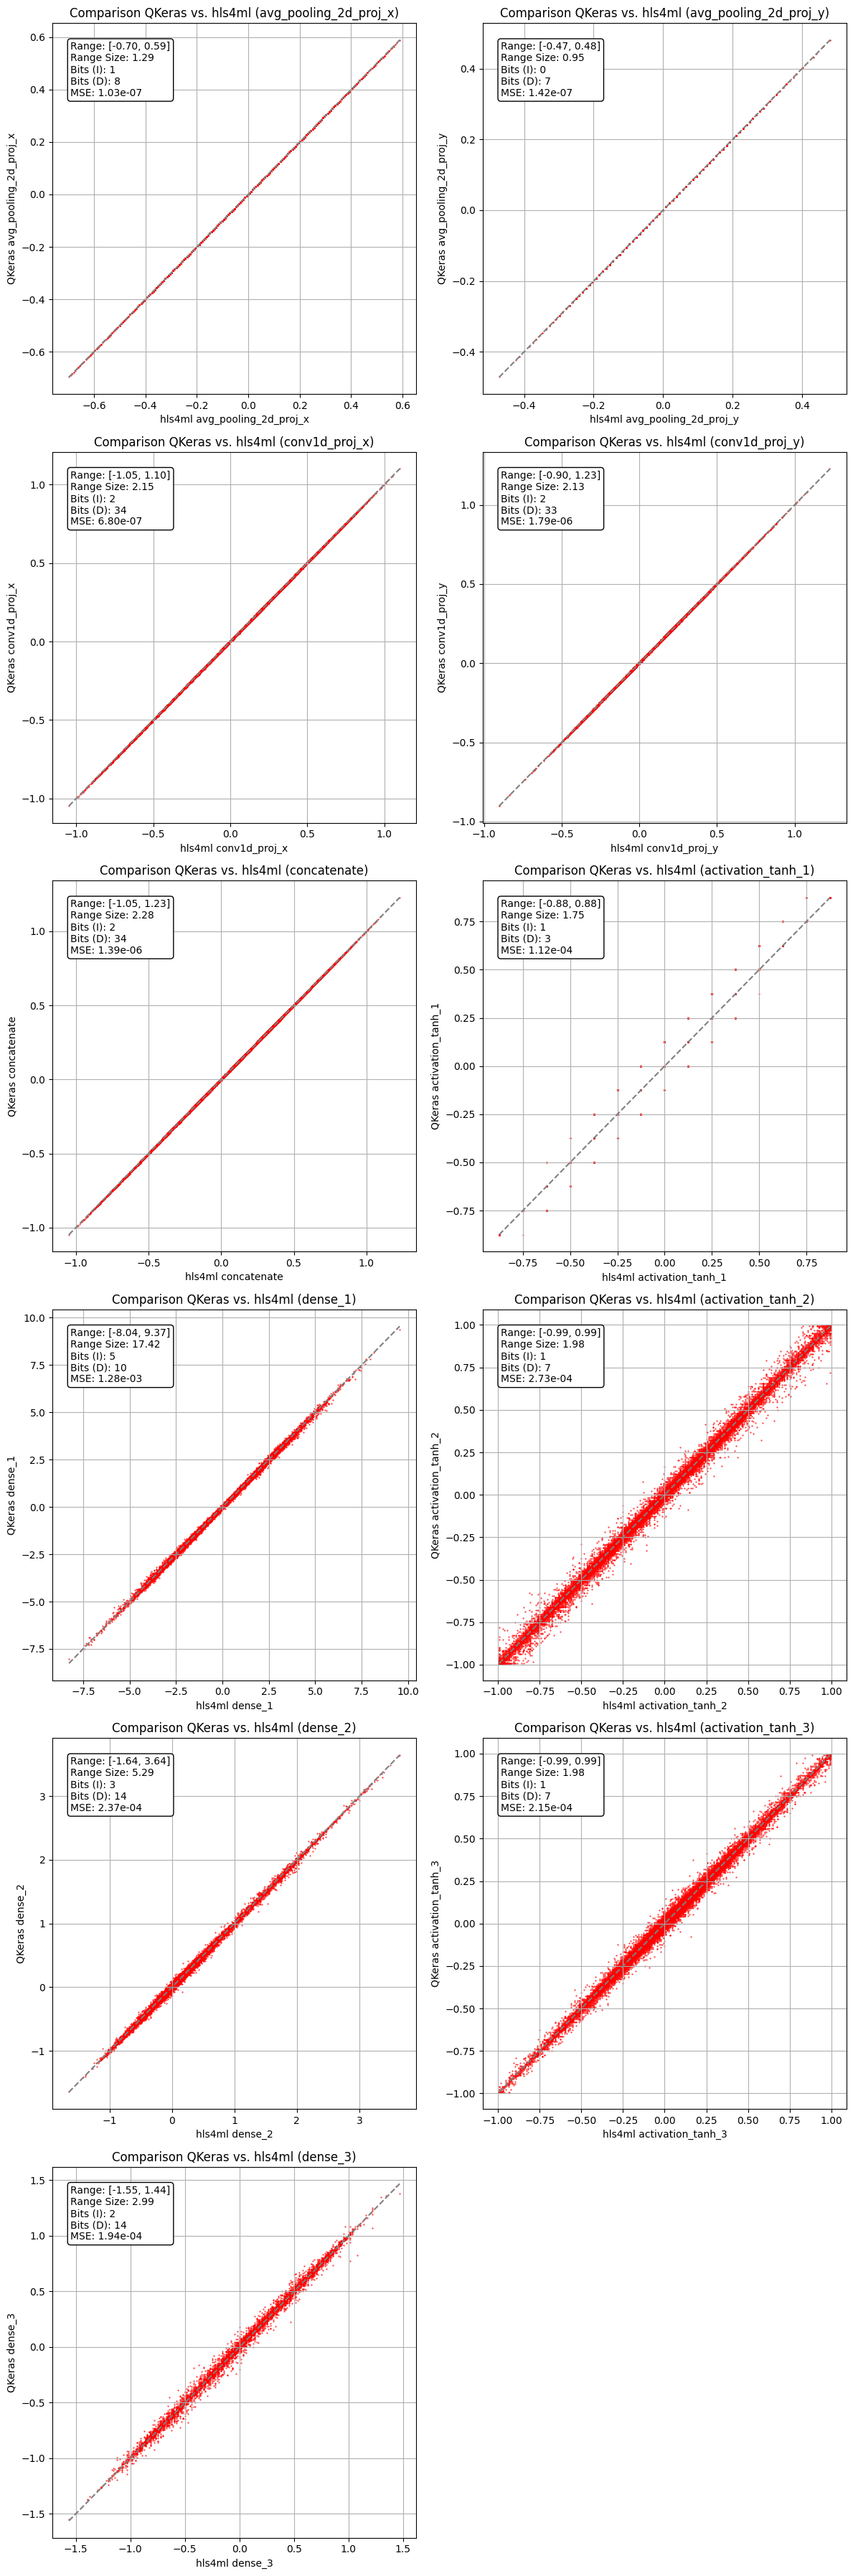

In [46]:
layers = [layer for layer in trace_hls4ml.keys() if "_alpha" not in layer and layer != "q_separable_conv2d_depthwise"]
num_layers = len(layers)

num_columns = 2
num_rows = math.ceil(num_layers / num_columns)

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 6 * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through layers and plot
for i, layer in enumerate(layers):
    klayer = layer.replace("_pointwise", "").replace("_linear", "")

    min_x = min(np.amin(trace_hls4ml[layer]), np.amin(trace_qkeras[klayer]))
    max_x = max(np.amax(trace_hls4ml[layer]), np.amax(trace_qkeras[klayer]))

    x = trace_hls4ml[layer].flatten()
    y = trace_qkeras[klayer].flatten()

    golden_min_x = np.amin(trace_qkeras[klayer])
    golden_max_x = np.amax(trace_qkeras[klayer])
    range_size = abs(golden_min_x) + abs(golden_max_x)
    integer_bits = math.ceil(math.log2(range_size))
    min_abs_value = np.min(np.abs(trace_qkeras[klayer][trace_qkeras[klayer] != 0]))
    if min_abs_value > 0:
        decimal_bits = abs(math.floor(math.log2(min_abs_value)))
    else:
        decimal_bits = 0  # If no non-zero value exists
    mse_value = np.mean((x - y) ** 2)

    ax = axes[i]
    ax.plot([min_x, max_x], [min_x, max_x], color="gray", linestyle="--", label="Diagonal")
    scatter = ax.scatter(x, y, s=0.2, color="red", label="Data Points")
    
    stats_text = (
        f"Range: [{golden_min_x:.2f}, {golden_max_x:.2f}]\n"
        f"Range Size: {range_size:.2f}\n"
        f"Bits (I): {integer_bits}\n"
        f"Bits (D): {decimal_bits}\n"
        f"MSE: {mse_value:.2e}"
    )
    ax.text(
        0.05, 0.95, stats_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

    ax.set_xlabel(f"hls4ml {layer}")
    ax.set_ylabel(f"QKeras {klayer}")
    ax.set_title(f"Comparison QKeras vs. hls4ml ({klayer})")
    ax.grid(True)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig(f"{model_name}_comparison_qkeras_hls4ml.jpeg")
plt.show()


## Model synthesis

In [47]:
# If a model is sliced, we don't run HLS, but here we can force HLS anyway
force_synthesis_sliced_model = True

In [48]:
%%time

# TODO: Check the parameters for the build function (Catapult)

#report = hls_model.build(csim=True, synth=False, cosim=False, validation=False, export=False, vsynth=False, reset=False)
if sliced_model_enable and not force_synthesis_sliced_model:
    print("*** Model slicing is enabled, thus disable synthesis ***")
else:
    report = hls_model_hls4ml.build(csim=True, synth=False, cosim=False, validation=False, BuildBUP=build_bup)

HLS4ML build() option 'cosim' is being depricated. Use 'SCVerify'
HLS4ML build() option 'validation' is being depricated. Use 'SCVerify'
HLS4ML build() option 'synth' is being depricated. Use 'Synth'
Catapult backend build() option overrides: "reset=False csim=True BuildBUP=False"
catapult -product ultra -shell -f build_prj.tcl -eval 'set ::argv "reset=False csim=True BuildBUP=False"'
//  Catapult Ultra Synthesis 2024.2_2/1156857 (Production Release) Tue Jan 14 16:38:07 PST 2025
//  
//          Copyright (c) Siemens EDA, 1996-2025, All Rights Reserved.
//                        UNPUBLISHED, LICENSED SOFTWARE.
//             CONFIDENTIAL AND PROPRIETARY INFORMATION WHICH IS THE
//                   PROPERTY OF SIEMENS EDA OR ITS LICENSORS.
//  
//  Running on Linux giuseppe@thorin:3970493 6.8.0-47-generic x86_64 aol
//  
//  Package information: SIFLIBS v27.2_2.0, HLS_PKGS v27.2_2.0, 
//                       SIF_TOOLKITS v27.2_2.0, SIF_XILINX v27.2_2.0, 
//                       SIF_A

### Results

## Save data for off-line debug

### Inputs and outputs

### Weights

<b style="background-color: yellow; color: red">ATTENTION: weights in .txt files from hls4ml are _different_.</b>

## Force pipelining

To apply pipelining for the top-level main function of each block:
```
go assembly
set blocks [solution get /HIERCONFIG/USER_HBS/*/RESOLVED_NAME -match glob -rec 1 -ret v -state analyze]
set top [lindex $blocks 0]
foreach block [lreverse [lrange $blocks 1 end]] {
  if { [string match {nnet::*} $block] == 0 } { continue }
  puts $block
  directive set /$top/$block/core/main -PIPELINE_INIT_INTERVAL 1
}

go extract
```

To generate hls4ml / Catapult AI NN report:
```
flow run /HLS4ML/collect_reports
```

Catapult 2024.2_1, 2024.2_2

```
Layer
=====
----------------------------------------------------------------------------------------------------------------  ------  --  ------  -------  -------  --------  ------  -------
Layer                                                                                                             Unroll  II  Area    Latency  Thruput  TotalPwr  DynPwr  LeakPwr
----------------------------------------------------------------------------------------------------------------  ------  --  ------  -------  -------  --------  ------  -------
nnet::depthwise_conv_2d_cl<input_t,q_separable_conv2d_depthwise_result_t,config19>                                            6188    273      273      NaN       NaN     NaN    
nnet::pointwise_conv_2d_cl<q_separable_conv2d_depthwise_result_t,q_separable_conv2d_pointwise_result_t,config21>              1637    209      209      NaN       NaN     NaN    
nnet::hard_tanh<q_separable_conv2d_pointwise_result_t,layer4_t,hard_tanh_config4>                                             672     209      209      NaN       NaN     NaN    
nnet::pointwise_conv_2d_cl<layer4_t,q_conv2d_result_t,config22>                                                               1422    209      209      NaN       NaN     NaN    
nnet::hard_tanh<q_conv2d_result_t,layer7_t,hard_tanh_config7>                                                                 570     209      209      NaN       NaN     NaN    
nnet::pooling2d_cl<layer7_t,layer8_t,config8>                                                                                 3447    209      209      NaN       NaN     NaN    
nnet::linear<layer8_t,layer9_t,linear_config9>                                                                                339     18       18       NaN       NaN     NaN    
nnet::dense<layer9_t,q_dense_result_t,config11>                                                                               212730  18       18       NaN       NaN     NaN    
nnet::hard_tanh<q_dense_result_t,layer13_t,hard_tanh_config13>                                                                2342    1        1        NaN       NaN     NaN    
nnet::dense<layer13_t,q_dense_1_result_t,config14>                                                                            38041   1        1        NaN       NaN     NaN    
nnet::hard_tanh<q_dense_1_result_t,layer16_t,hard_tanh_config16>                                                              2342    1        1        NaN       NaN     NaN    
nnet::dense<layer16_t,result_t,config17>                                                                                      33335   1        1        NaN       NaN     NaN    

FIFO Interconnect
=================
------------  --------------------  -----------------------  -----  -----  ----
C++ Variable  Instance              Component                Width  Depth  Area
------------  --------------------  -----------------------  -----  -----  ----
layer11_out   layer11_out_cns_pipe  hls4ml_lib.mgc_pipe_mem  256    1      1122
layer13_out   layer13_out_cns_pipe  hls4ml_lib.mgc_pipe_mem  128    1      562 
layer14_out   layer14_out_cns_pipe  hls4ml_lib.mgc_pipe_mem  256    1      1122
layer16_out   layer16_out_cns_pipe  hls4ml_lib.mgc_pipe_mem  128    1      562 
layer19_out   layer19_out_cns_pipe  hls4ml_lib.mgc_pipe_mem  32     1      142 
layer20_out   layer20_out_cns_pipe  hls4ml_lib.mgc_pipe_mem  80     1      352 
layer4_out    layer4_out_cns_pipe   hls4ml_lib.mgc_pipe_mem  20     1      89  
layer5_out    layer5_out_cns_pipe   hls4ml_lib.mgc_pipe_mem  60     1      264 
layer7_out    layer7_out_cns_pipe   hls4ml_lib.mgc_pipe_mem  20     1      89  
layer8_out    layer8_out_cns_pipe   hls4ml_lib.mgc_pipe_mem  60     1      264 
layer9_out    layer9_out_cns_pipe   hls4ml_lib.mgc_pipe_mem  40     1      177 

Weight/Bias Value ROM Constants
===============================
-----  --------  -----------
Layer  Variable  Size (bits)
-----  --------  -----------
5      b5        20         
5      w5        100        
11     b11       128        
11     w11       11520      
14     w14       256x8      
14     b14       128        
17     w17       1792       
17     b17       112        
19     b19       2          
19     w19       72         
20     b20       20         
20     w20       10x4       
```